## Monte Carlo Simulation

For today's session, we will no longer be performing simulations using molecular dynamics. Instead, we will be using the second of the "Big 2" simulation approaches: Monte Carlo.

Monte Carlo (MC) offers several advantages and disadvantages over molecular dynamics (MD), and it will depend on the system and problem of interest as to which simulation approach is appropriate. For systems where large energy barriers can result in systems that are easily trapped in local minima, MC can provide a significant advantage over MD. However, typically there is no "time" in a Monte Carlo simulation, thus properties that require time-averaging can no be assessed via MC.

In this session, you will introduced to the basics of MC through simulations of a simple Lennard-Jones system (comparable to the system you performed MD simulations of on Tuesday). While several open-source, highly-optimized MD codes exist (you have already been introduced to HOOMD and GROMACS), relatively few MC codes exist. As a result, for this session we will be using an ad hoc MC code written in C++, that has been wrapped in Python for clarity. We will explore some of the underlying code and observe how changing various run parameters effect the result of the simulation.

### Importing the MC Code

The MC code is contained in several files located in the `src` directory. Modules exist for the LJ force field, the LJ system, and the Monte Carlo algorithm. We will import these three classes here.

In [1]:
from src import ForceField, LJBox, MonteCarlo

### Define the force field

Let's define the Lennard-Jones parameters that will dictate how our particles will interact with one another. In the box below we will define values for `sigma`, `epsilon`, and `cutoff`. Recall these parameters from the Lennard-Jones equation:

\begin{align}
U_{LJ} = 4 \epsilon \left [ {\left ( \frac{\sigma}{r} \right )} ^{12} - {\left ( \frac{\sigma}{r} \right )} ^{6} \right ],\: r \le r_{cut}
\end{align}

We will begin by using a sigma of 1.0, an epsilon of 1.0, and a cutoff of 2.5.

In [2]:
sigma = 1.0 
epsilon = 1.0 
cutoff = 2.5 

forcefield = ForceField(sigma=sigma, epsilon=epsilon, cutoff=cutoff)

For this code, force field parameters are stored within a `ForceField` object. Let's take a quick look at this (simple) class.

In [3]:
!cat src/forcefield.py

from __future__ import division

import matplotlib.pyplot as plt
import numpy as np

class ForceField():
    def __init__(self, sigma, epsilon, cutoff):
        self.sigma = sigma
        self.epsilon = epsilon
        self.cutoff = cutoff

    def show(self):
        cms = self.cutoff - self.sigma
        rmin = self.sigma - cms * 0.1
        rmax = self.cutoff + cms * 0.1
        rvals = np.linspace(rmin, rmax, 100)

        s_over_r = self.sigma / rvals
        U = 4 * self.epsilon * (s_over_r ** 12 - s_over_r ** 6)
        min_U = np.min(U)

        fig, ax = plt.subplots()
        ax.plot(rvals, U, linestyle='-', color='#6666ff', lw=4)
        ax.set_xlim(rmin, rmax)
        ax.set_ylim(min_U * 1.1, -0.1 * min_U)
        ax.set_xlabel('r')
        ax.set_ylabel('U')

        plt.show()


As we can see above, the `ForceField` class simply features a constructor to load force field information into several class attributes and a `show` method to plot the force field.

Let's use the `show` method here to obtain a better appreciation for the force field we've defined.

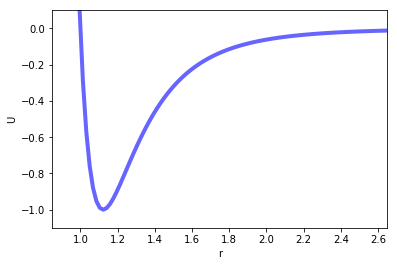

In [4]:
forcefield.show()

#### Define system parameters

Now we want to define our system parameters. For this system these parameters will be the total number of particles and the number density of particles to place in the box.

We will begin by defining a system of 216 particles and a number density of 0.7.

In [5]:
n_particles = 216 
number_density = 0.7

The `LJBox` class will take these system parameters and use mBuild to create the system. Let's take a quick look at that class.

In [6]:
!cat src/ljbox.py

from __future__ import division

import mbuild as mb
import numpy as np


class LJBox(mb.Compound):
    """
    Parameters
    ----------
    n : int
        Number of particles in the system
    density : float
        Number density of particles in the system
    """
    def __init__(self, n, density):
        super(LJBox, self).__init__()

        box_length = (n / density) ** (1 / 3)
        box = mb.Box(lengths=np.ones(3) * box_length)

        print("Creating box ({:.4f} x {:.4f} x {:.4f}) containing {} particles at a "
              "number density of {}.".format(*box.lengths, n, density))

        particles_per_len = round(n ** (1 / 3))
        pattern = mb.Grid3DPattern(particles_per_len, particles_per_len,
                                   particles_per_len)
        pattern.scale(box_length)
        for pos in pattern:
            self.add(mb.Particle(name='_LJ', pos=pos - box.lengths / 2))
        self.periodicity = box.lengths


In [7]:
system = LJBox(n_particles, number_density)

Creating box (6.7575 x 6.7575 x 6.7575) containing 216 particles at a number density of 0.7.


#### Define Monte Carlo parameters

Now let's define the parameters for our Monte Carlo simulation. There are several parameters that we need to define:
  - Temperature &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; Recall $\beta = 1 / {k_B T}$
  - $\Delta_{x, init}$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp;&nbsp;&nbsp; Initial maximum particle displacement
  - Acceptance probability &nbsp; &nbsp; &nbsp; At what probability do we want move to be accepted?
  - $n_{relax}$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Number of steps to relax from the initial configuration
  - $n_{MC}$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp;&nbsp; Number of MC steps to perform after the relaxation period

In [9]:
temperature = 1.2
dx = 0.1            # Initial maximum displacement
target = 0.5        # Target acceptance probabality
n_relax = 10000     # Number of steps to relax from initial configuration
n_mc = 500000       # Total number of MC steps

We will feed these parameters into the constructor for a `MonteCarlo` object. Let's look at that class:

In [ ]:
mc = MonteCarlo(forcefield=forcefield,
                system=system,
                dx=dx,
                temperature=temperature,
                target=target)

#### Relax the system

In [ ]:
mc.relax(n_relax, adjust_freq=100)

In [ ]:
import nglview as nv
import mdtraj as md
traj = md.load('relax.xyz', top='system_init.gro')
nv.show_mdtraj(traj, representations=[{'type': 'spacefill', 'params': {'radius': 0.5}}])

#### Perform production Monte Carlo run

In [ ]:
mc.run(n_mc)

#### View the trajectory

#### Analyze the radial distribution function